In [1]:
import pandas as pd
import numpy as np
import requests
import os
import json
from bs4 import BeautifulSoup
from fuzzyset import FuzzySet
from matplotlib import pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool
import psutil

from workers import *

In [2]:
# coefficient for gamma
gexp = 0.2

In [3]:
# get GeoJSON for countries
# https://github.com/johan/world.geo.json
geofile = 'countries.geo.json'
geourl = 'https://raw.githubusercontent.com/johan/world.geo.json/master/' + geofile
if not os.path.exists(geofile):
    req = requests.get(geourl)
    with open(geofile, 'wb') as f:
        f.write(req.content)

with open(geofile) as f:
    geos = json.load(f)
#geos

In [4]:
# population data source
popurl = 'https://www.worldometers.info/world-population/population-by-country/'
popcsv = 'world_pop.csv'

# download population data
if not os.path.exists(popcsv):
    page = requests.get(popurl)
    soup = BeautifulSoup(page.content, 'html.parser')

    # this is stupid HTML voodoo, I feel sorry for your eyes
    # anyway, there's a big table on that page, let's extract it
    html = list(soup.children)[6]
    body = list(html.children)[4]
    big = list(body.children)[3]
    big2 = list(big.children)[4]
    big3 = list(big2.children)[1]
    bigtable = soup.find('table', attrs={'id': 'example2'})
    bt_head = bigtable.find('thead')

    # this is what we want
    bt_body = bigtable.find('tbody')
    rows = bt_body.find_all('tr')
    popt_head = ['Country', 'Population']
    popdf = []
    for r in rows:
        cells = r.find_all('td')
        mname = cells[1]
        name = mname.find('a', href=True).text
        mpop = cells[2]
        pop = int(mpop.text.replace(',', ''))
        poprow = [name, pop]
        popdf.append(poprow)

    populations = pd.DataFrame(popdf, columns=popt_head)
    # got the whole thing, save it
    populations.to_csv(popcsv, index=False, line_terminator='\n')

# (re)load from disk
pops = pd.read_csv(popcsv)
pops

,Country,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340
...,...,...
230,Montserrat,4992
231,Falkland Islands,3480
232,Niue,1626
233,Tokelau,1357


In [5]:
# get COVID-19 data
# this should be updated daily
# https://github.com/CSSEGISandData/COVID-19
tsfile = 'time_series_covid19_confirmed_global.csv'
tsurl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/' + tsfile
if not os.path.exists(tsfile):
    req = requests.get(tsurl)
    with open(tsfile, 'wb') as f:
        f.write(req.content)

# there is no data for some countries:
# https://github.com/CSSEGISandData/COVID-19/issues/2228

In [6]:
c19 = pd.read_csv(tsfile)

# we don't care about lat/long and province data
c19.drop(columns = ['Lat', 'Long', 'Province/State'], inplace = True)
dates = c19.columns.tolist()[1:]

# group by countries that have multiple rows,
# sum the values, and convert them into single row
c19 = c19.groupby('Country/Region')[dates].sum().copy(deep=True)
# flip rows and columns
c19 = c19.transpose(copy=True)
c19.columns.name = None

# the original dataframe has cumulative cases
# we want daily cases (differential)
# so let's calculate the diff
c19 = c19.diff(axis=0).copy(deep=True)
# the differential nukes the first row, let's fill it back in with 0
c19.loc['1/22/20'] = 0
# there are negative values because "magic"
# clip those off
c19.clip(lower=0, inplace=True)
# smooth the data
c19 = c19.rolling(21, min_periods=1, center=True, win_type='blackmanharris').mean().copy(deep=True)

In [7]:
# list of countries from geo data
geoctrs = [feat['properties']['name'] for k, feat in enumerate(geos['features'])]

# list of countries from C19 data
c19ctrs = c19.columns.tolist()

# list of countries from population data
popsctrs = pops['Country'].tolist()

# geo data is king, we need to match everything else to it
# the country name becomes the key matching the tables / dictionaries

# some countries in c19 do not match any country in geo data
# let's print fuzzy matches
fzs = FuzzySet()
for c in geoctrs:
    fzs.add(c)

#for c in c19ctrs:
#    if c not in geoctrs:
#        print(c, fzs.get(c))

In [8]:
c19notfound = [
    'Andorra',
    'Antigua and Barbuda',
    'Bahrain',
    'Barbados',
    'Cabo Verde',
    'Comoros',
    'Diamond Princess',
    'Dominica',
    'Grenada',
    'Holy See',
    'Liechtenstein',
    'MS Zaandam',
    'Maldives',
    'Mauritius',
    'Monaco',
    'Saint Kitts and Nevis',
    'Saint Lucia',
    'Saint Vincent and the Grenadines',
    'San Marino',
    'Sao Tome and Principe',
    'Seychelles',
    'Singapore'
]

c19partm = {
    'Bahamas': 'The Bahamas',
    'Cote d\'Ivoire': 'Ivory Coast',
    'Congo (Kinshasa)': 'Democratic Republic of the Congo',
    'Congo (Brazzaville)': 'Republic of the Congo',
    'Czechia': 'Czech Republic',
    'Guinea-Bissau': 'Guinea Bissau',
    'Korea, South': 'South Korea',
    'North Macedonia': 'Macedonia',
    'Burma': 'Myanmar',
    'Serbia': 'Republic of Serbia',
    'Eswatini': 'Swaziland',
    'Timor-Leste': 'East Timor',
    'Taiwan*': 'Taiwan',
    'Tanzania': 'United Republic of Tanzania',
    'US': 'United States of America',
    'West Bank and Gaza': 'West Bank'
}

c19.rename(columns=c19partm, inplace=True)
c19.drop(columns=c19notfound, inplace=True)

# if nothing is printed by this loop,
# then every country in c19 matches a country in geo data
for c in c19.columns.tolist():
    if c not in geoctrs:
        print(c, fzs.get(c))

In [9]:
# let's fix country names in population data

fzs = FuzzySet()
for c in popsctrs:
    fzs.add(c)

popnotfound = [
    'Kosovo',
    'West Bank'
]

poppartm = {
    'Bahamas': 'The Bahamas',
    'Brunei ': 'Brunei',
    'DR Congo': 'Democratic Republic of the Congo',
    'Congo': 'Republic of the Congo',
    'Côte d\'Ivoire': 'Ivory Coast',
    'Czech Republic (Czechia)': 'Czech Republic',
    'Eswatini': 'Swaziland',
    'Guinea-Bissau': 'Guinea Bissau',
    'North Macedonia': 'Macedonia',
    'Serbia': 'Republic of Serbia',
    'Tanzania': 'United Republic of Tanzania',
    'Timor-Leste': 'East Timor',
    'United States': 'United States of America'
}

# drop from c19
c19.drop(columns=popnotfound, inplace=True)

# rename in pop
pops['Country'] = pops['Country'].replace(poppartm).copy(deep=True)

# if nothing is printed by this loop,
# then every country in c19 matches a country in population data
for c in c19.columns.tolist():
    if c not in pops['Country'].tolist():
        print(c)

In [10]:
# calculate relative (per capita) values
c19rel = c19.copy(deep=True)
for c in c19rel.columns.tolist():
    popnum = pops.loc[pops['Country'] == c, 'Population'].values[0]
    c19rel[c] = c19rel[c] / popnum

In [11]:
color_abs = assign_colors(c19)
color_rel = assign_colors(c19rel)
plot_scope = 'World'

data_type = 'plain numbers'
plot_folder = make_folder_name('plot', plot_scope, data_type)
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
make_plots(c19, plot_folder, 'countries', color_abs, data_type, plot_scope, False, True)

data_type = 'per capita'
plot_folder = make_folder_name('plot', plot_scope, data_type)
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
make_plots(c19rel, plot_folder, 'countries', color_rel, data_type, plot_scope, False, True)

In [12]:
c19g = c19.apply(gamma, g=gexp, max=np.unique(c19).tolist()[-1])
c19relg = c19rel.apply(gamma, g=gexp, max=np.unique(c19rel).tolist()[-1])

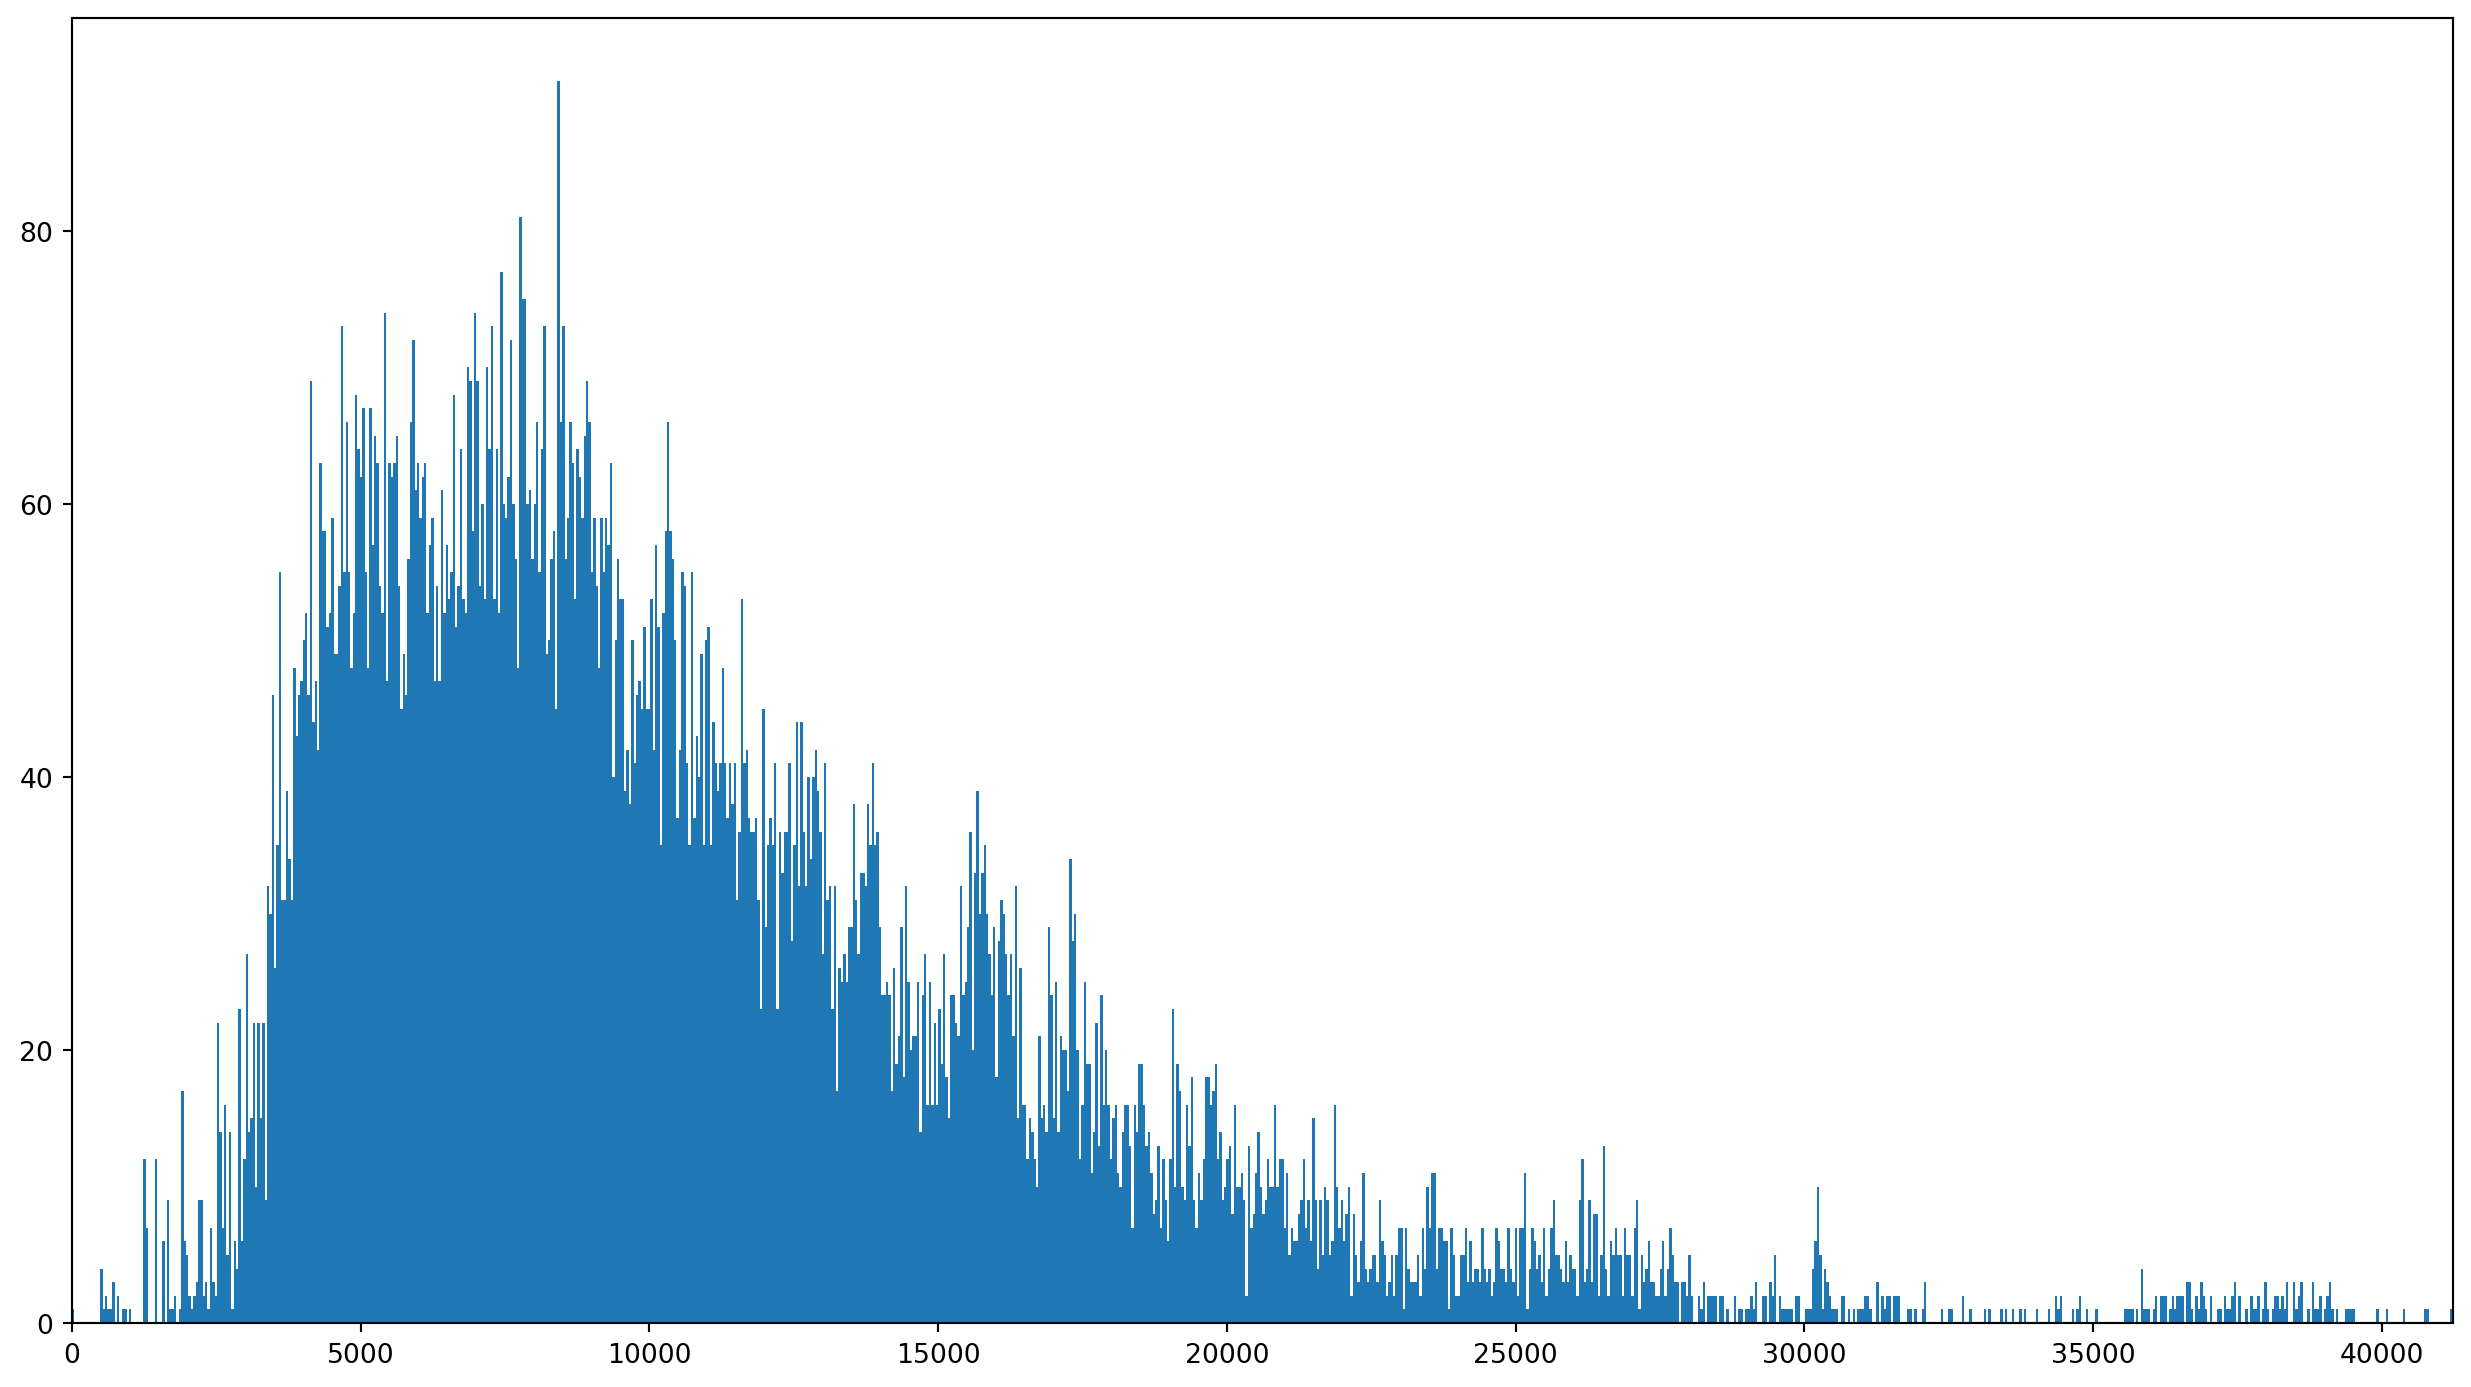

In [13]:
# sanity check for gamma

# distribution of values
# do not apply a gamma correction so drastic that values will peel off the 0 axis
# the curve should (barely) touch zero on the left, or else gamma is too strong
plt.figure(figsize=(16, 9))
histvals = np.unique(c19g).tolist()
plt.xlim([0, histvals[-1]])
_ = plt.hist(np.unique(c19g).tolist(), bins=1000)

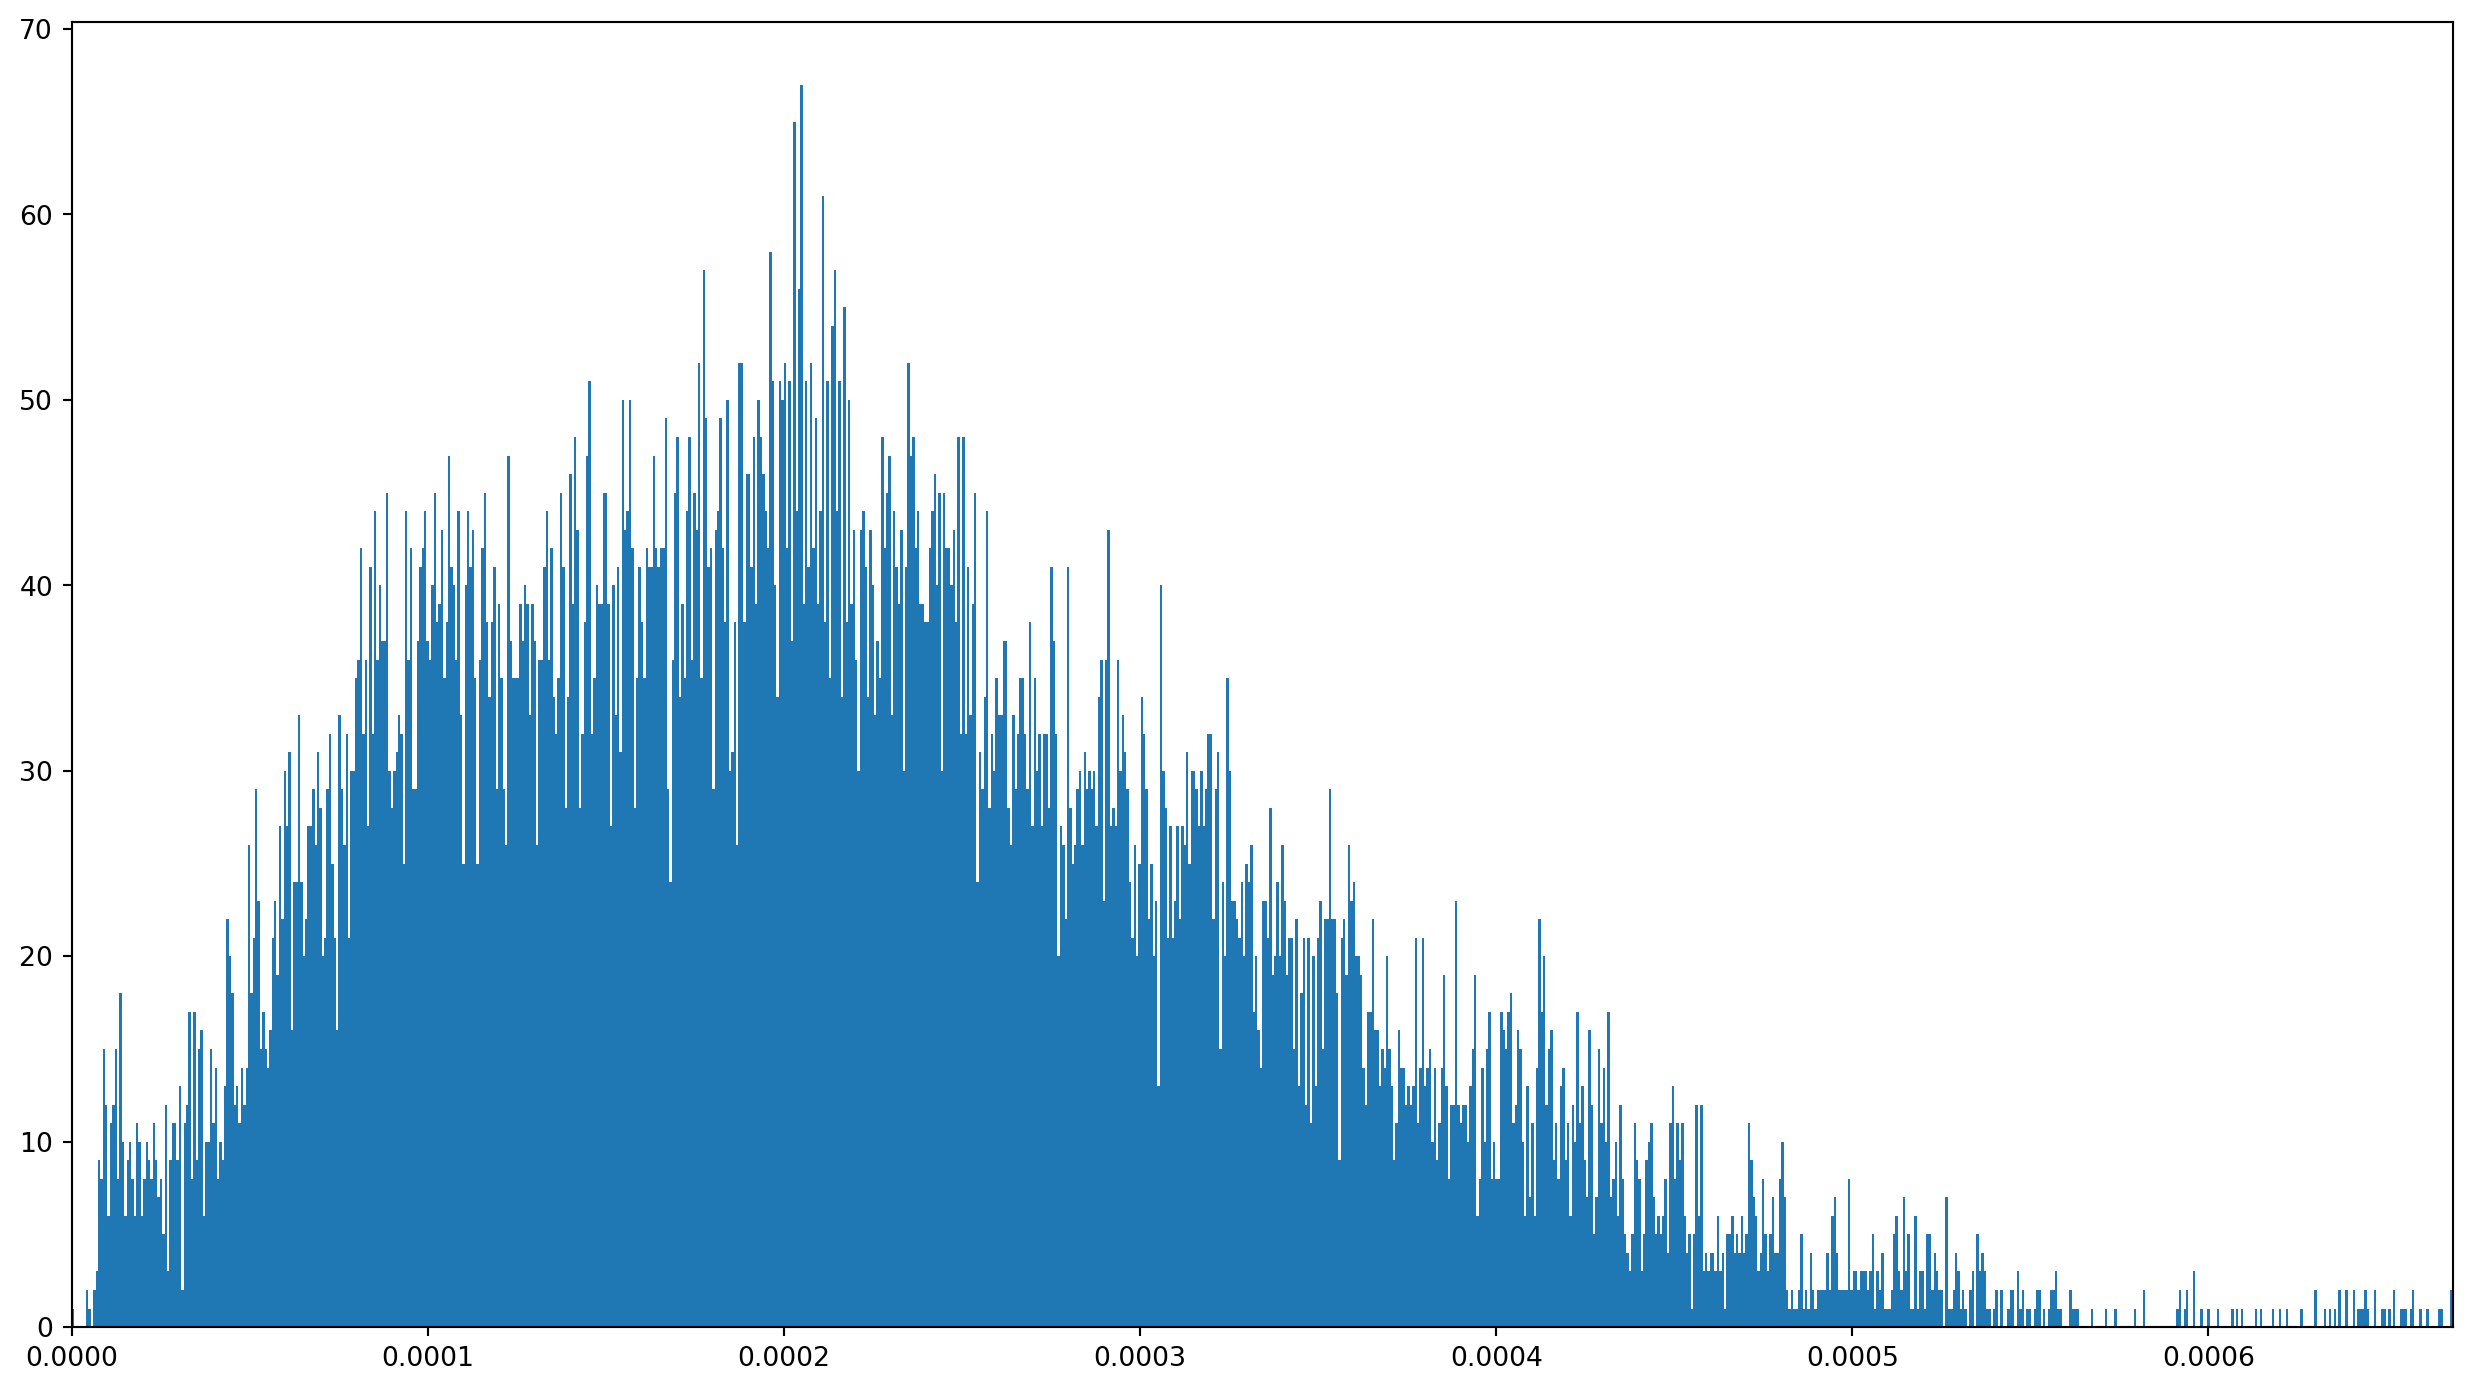

In [14]:
# distribution of values
plt.figure(figsize=(16, 9))
histvals = np.unique(c19relg).tolist()
plt.xlim([0, histvals[-1]])
_ = plt.hist(np.unique(c19relg).tolist(), bins=1000)

In [15]:
# With iPython and/or Windows you have to put the worker control in __main__
# and the worker function in a separate module. Fails otherwise.
# Linux / plain Python don't have this issue.
if __name__ == '__main__':
    # one worker per CPU
    workers = psutil.cpu_count(logical = False)
    # MP voodoo. spawn seems to work on Mac and Win.
    # Other methods fail in bizarre ways.
    mp.set_start_method('spawn')
    
    map_scope = 'World'
    map_geom = (25, 15, 1.9, 1920, 1080)
    title_geom = (0.03, 0.06, 32)

    for map_bundle in [(c19g, 'plain numbers'), (c19relg, 'per capita')]:
        data_type = map_bundle[1]
        map_folder = make_folder_name('map', map_scope, data_type)
        if not os.path.exists(map_folder):
            os.makedirs(map_folder)
        bar_ticks = makebarticks(map_bundle[0], gexp, 10)
        
        # distribute the list of dates (indexes) equally among all workers (round-robin)
        wdlist = [[] for _ in range(workers)]
        for ind, val in enumerate(map_bundle[0].index.tolist()):
            wdlist[ind % workers].append(val)
        
        # build argument tuples for workers - list of tuples
        # each tuple is the argument for one worker
        # they all get the same stuff, except the list of dates in the dataframe is divided among them
        # each tuple elements are arguments for make_map()
        warglist = [(map_bundle[0].loc[wdlist[w]], geos, 'properties.name', map_scope, 'countries', map_geom, map_bundle[1], title_geom, map_folder, gexp, bar_ticks, None) for w in range(workers)]
        
        # Start the pool, then break it down after each data type.
        # Probably safer this way.
        p = Pool(processes = workers)
        work_out = p.map(make_map, warglist)
        p.close()

In [16]:
# if all went well, write the most recent timestamp in the data to a file
with open('last-day-world.txt', 'w') as f:
    f.write(lfill_date(c19.index.tolist()[-1]))